In [ ]:
import os
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install einops

In [ ]:
%%bash
cd /content/drive/MyDrive/MuralinkWorkflows/
git clone https://github.com/comfyanonymous/ComfyUI
git clone https://github.com/nullquant/ComfyUI-BrushNet
cd ComfyUI
pip install -r requirements.txt
cd ..
cd ComfyUI-BrushNet
pip install -r requirements.txt
cd ..


In [ ]:
%%bash
cd /content/drive/MyDrive/MuralinkWorkflows/ComfyUI
pip install -r requirements.txt
cd ..
cd ComfyUIBrushNet
pip install -r requirements.txt
cd ..

In [ ]:
import sys
comfy_path = "/content/drive/MyDrive/MuralinkWorkflows/ComfyUI"
comfy_brushnet_path = "/content/drive/MyDrive/MuralinkWorkflows/ComfyUIBrushNet"
sys.path.append(comfy_path)
sys.path.append(comfy_brushnet_path)
sys.path.append('/content/drive/MyDrive/MuralinkWorkflows/')

In [ ]:
%%bash
cd /content/drive/MyDrive/MuralinkWorkflows/Checkpoints/
ls

dynavision.safetensors
realisticVisionV60B1_v51VAE
segmentation_mask_brushnet_ckpt


In [ ]:
#sys.path.remove('/content/drive/MyDrive/MuralinkWorkflows/ComfyUI-BrushNet')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/drive/MyDrive/MuralinkWorkflows/ComfyUI',
 '/content/drive/MyDrive/MuralinkWorkflows/ComfyUIBrushNet',
 '/tmp/tmp_d9yz0bk']

In [ ]:
%%bash
ls

drive
sample_data


In [ ]:
LoadImage()

In [ ]:
from ComfyUIBrushNet.brushnet_nodes import (
    BrushNet,
    BrushNetLoader,
    BlendInpaint
)

In [ ]:
from ComfyUI.folder_paths import get_filename_list

In [ ]:
import torch
from torch import Tensor
import torchvision

import torch.nn.functional as F
import kornia.filters
import numpy as np
from PIL import Image
import cv2

import math

from typing import Optional, Union, Tuple, List
import einops

from ComfyUI.nodes import (
    KSampler,
    CheckpointLoaderSimple,
    CLIPTextEncode,
    CLIPSetLastLayer,
    VAEDecode,
    VAEEncode,
    VAEEncodeTiled,
    LoadImage,
    RepeatLatentBatch
)
from ComfyUI.comfy_extras.nodes_mask import (
    GrowMask,
)

from ComfyUIBrushNet.brushnet_nodes import (
    BrushNet,
    BrushNetLoader,
    BlendInpaint
)

from ComfyUI.comfy_extras.nodes_differential_diffusion import DifferentialDiffusion
from ComfyUI.comfy_extras.nodes_pag import PerturbedAttentionGuidance

def mask_unsqueeze(mask: Tensor):
    if len(mask.shape) == 3:  # BHW -> B1HW
        mask = mask.unsqueeze(1)
    elif len(mask.shape) == 2:  # HW -> B1HW
        mask = mask.unsqueeze(0).unsqueeze(0)
    #TODO: Need to check whether the current code scales up properly to batch performance
    elif len(mask.shape) ==4:
      mask = einops.rearrange(mask, 'b h w c -> b c h w')[:, 0, :, :]
    return mask

def mask_floor(mask: Tensor, threshold: float = 0.99):
    return (mask >= threshold).to(mask.dtype)

def make_odd(x):
    if x > 0 and x % 2 == 0:
        return x + 1
    return x

def fit_resize_image(image:Image, target_width:int, target_height:int, fit:str, resize_sampler:str, background_color:str = '#000000') -> Image:
    image = image.convert('RGB')
    orig_width, orig_height = image.size
    if image is not None:
        if fit == 'letterbox':
            if orig_width / orig_height > target_width / target_height:
                fit_width = target_width
                fit_height = int(target_width / orig_width * orig_height)
            else:
                fit_height = target_height
                fit_width = int(target_height / orig_height * orig_width)
            fit_image = image.resize((fit_width, fit_height), resize_sampler)
            ret_image = Image.new('RGB', size=(target_width, target_height), color=background_color)
            ret_image.paste(fit_image, box=((target_width - fit_width)//2, (target_height - fit_height)//2))
        elif fit == 'crop':
            if orig_width / orig_height > target_width / target_height:
                fit_width = int(orig_height * target_width / target_height)
                fit_image = image.crop(
                    ((orig_width - fit_width)//2, 0, (orig_width - fit_width)//2 + fit_width, orig_height))
            else:
                fit_height = int(orig_width * target_height / target_width)
                fit_image = image.crop(
                    (0, (orig_height-fit_height)//2, orig_width, (orig_height-fit_height)//2 + fit_height))
            ret_image = fit_image.resize((target_width, target_height), resize_sampler)
        else:
            ret_image = image.resize((target_width, target_height), resize_sampler)
    return  ret_image

def tensor2pil(t_image: torch.Tensor)  -> Image:
    return Image.fromarray(np.clip(255.0 * t_image.cpu().numpy().squeeze(), 0, 255).astype(np.uint8))

def pil2tensor(image:Image) -> torch.Tensor:
    return torch.from_numpy(np.array(image).astype(np.float32) / 255.0).unsqueeze(0)

def binary_erosion(mask: Tensor, radius: int):
    kernel = torch.ones(1, 1, radius * 2 + 1, radius * 2 + 1, device=mask.device)
    mask = F.pad(mask, (radius, radius, radius, radius), mode="constant", value=1)
    mask = F.conv2d(mask, kernel, groups=1)
    mask = (mask == kernel.numel()).to(mask.dtype)
    return mask

def gaussian_blur(image: Tensor, radius: int, sigma: float = 0):
    c = image.shape[-3]
    if sigma <= 0:
        sigma = 0.3 * (radius - 1) + 0.8
    return kornia.filters.gaussian_blur2d(image, (radius, radius), (sigma, sigma))

def _tensor_check_mask(mask):
    if mask.ndim != 4:
        raise ValueError(f"Expected NHWC tensor, but found {mask.ndim} dimensions")
    if mask.shape[-1] != 1:
        raise ValueError(f"Expected 1 channel for mask, but found {mask.shape[-1]} channels")
    return

def load_image(image_path: str) -> Tuple[torch.Tensor, int, int]:
    """Load and preprocess image for BrushNet

    Args:
        image_path: Path to image file

    Returns:
        Tuple of (preprocessed tensor, width, height)
    """
    image = Image.open(image_path)
    width, height = image.size
    image = np.array(image).astype(np.float32) / 255.0
    image = torch.from_numpy(image)[None,...]
    return image, width, height

def prepare_mask(mask_path: str) -> torch.Tensor:
    """Load and preprocess mask for BrushNet

    Args:
        mask_path: Path to mask image

    Returns:
        Preprocessed mask tensor
    """
    mask = Image.open(mask_path)
    mask = mask.convert('L')
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = torch.from_numpy(mask)[None,...]
    return mask

class MaskedFill:
    @classmethod
    def INPUT_TYPES(s):
        return {
            "required": {
                "image": ("IMAGE",),
                "mask": ("MASK",),
                "fill": (["neutral", "telea", "navier-stokes"],),
                "falloff": ("INT", {"default": 0, "min": 0, "max": 8191, "step": 1}),
            }
        }

    RETURN_TYPES = ("IMAGE",)
    CATEGORY = "inpaint"
    FUNCTION = "fill"

    def fill(self, image: Tensor, mask: Tensor, fill: str, falloff: int):
        image = image.detach().clone()
        alpha = mask_unsqueeze(mask_floor(mask))
        assert alpha.shape[0] == image.shape[0], "Image and mask batch size does not match"

        falloff = make_odd(falloff)
        if falloff > 0:
            erosion = binary_erosion(alpha, falloff)
            alpha = alpha * gaussian_blur(erosion, falloff)

        if fill == "neutral":
            m = (1.0 - alpha).squeeze(1)
            for i in range(3):
                image[:, :, :, i] -= 0.5
                image[:, :, :, i] *= m
                image[:, :, :, i] += 0.5
        else:
            import cv2

            method = cv2.INPAINT_TELEA if fill == "telea" else cv2.INPAINT_NS
            for slice, alpha_slice in zip(image, alpha):
                alpha_np = alpha_slice.squeeze().cpu().numpy()
                alpha_bc = alpha_np.reshape(*alpha_np.shape, 1)
                image_np = slice.cpu().numpy()
                filled_np = cv2.inpaint(
                    (255.0 * image_np).astype(np.uint8),
                    (255.0 * alpha_np).astype(np.uint8),
                    3,
                    method,
                )
                filled_np = filled_np.astype(np.float32) / 255.0
                filled_np = image_np * (1.0 - alpha_bc) + filled_np * alpha_bc
                slice.copy_(torch.from_numpy(filled_np))

        return (image,)

Mapping = {
    "INPAINT_MaskedFill": MaskedFill
}

def make_3d_mask(mask):
    if len(mask.shape) == 4:
        return mask.squeeze(0)

    elif len(mask.shape) == 2:
        return mask.unsqueeze(0)

    return mask

def tensor_gaussian_blur_mask(mask, kernel_size, sigma=10.0):
    """Return NHWC torch.Tenser from ndim == 2 or 4 `np.ndarray` or `torch.Tensor`"""
    if isinstance(mask, np.ndarray):
        mask = torch.from_numpy(mask)

    if mask.ndim == 2:
        mask = mask[None, ..., None]
    elif mask.ndim == 3:
        mask = mask[..., None]

    _tensor_check_mask(mask)

    if kernel_size <= 0:
        return mask

    kernel_size = kernel_size*2+1

    shortest = min(mask.shape[1], mask.shape[2])
    if shortest <= kernel_size:
        kernel_size = int(shortest/2)
        if kernel_size % 2 == 0:
            kernel_size += 1
        if kernel_size < 3:
            return mask  # skip feathering

    prev_device = mask.device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mask.to(device)

    # apply gaussian blur
    mask = mask[:, None, ..., 0]
    blurred_mask = torchvision.transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)(mask)
    blurred_mask = blurred_mask[:, 0, ..., None]

    blurred_mask.to(prev_device)

    return blurred_mask

def image2mask(image:Image) -> torch.Tensor:
    if image.mode == 'L':
        return torch.tensor([pil2tensor(image)[0, :, :].tolist()])
    else:
        image = image.convert('RGB').split()[0]
        return torch.tensor([pil2tensor(image)[0, :, :].tolist()])

def num_round_up_to_multiple(number: int, multiple: int) -> int:
    remainder = number % multiple
    if remainder == 0:
        return number
    else:
        factor = (number + multiple - 1) // multiple
        return factor * multiple

def log(message:str, message_type:str='info'):
    name = 'LayerStyle'

    if message_type == 'error':
        message = '\033[1;41m' + message + '\033[m'
    elif message_type == 'warning':
        message = '\033[1;31m' + message + '\033[m'
    elif message_type == 'finish':
        message = '\033[1;32m' + message + '\033[m'
    else:
        message = '\033[1;33m' + message + '\033[m'
    print(f"# 😺dzNodes: {name} -> {message}")

def ensure_same_size(image: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Ensure image and mask have the same dimensions.
    Returns resized versions if they don't match.

    Args:
        image: Input image tensor (BCHW)
        mask: Input mask tensor (B1HW)

    Returns:
        Tuple of (resized_image, resized_mask)
    """
    if image is None or mask is None:
      print("Returning because either image or mask is none")
      return image, mask

    #TODO: This assumes we're working with a black and white mask.

    image_size = (image.shape[2], image.shape[1])  # (width, height)
    mask_size = (mask.shape[1], mask.shape[0])  # (width, height)

    #TODO: Remove in production
    print(f"Image size: {image_size}")
    print(f"Mask size: {mask_size}")

    if image_size == mask_size:
      print("returning directly because image and mask have same size")
      return (image, mask)

    # Use ImageScaleByAspectRatioV2 to resize to match largest dimension
    scaler = ImageScaleByAspectRatioV2()

    # Get target size (use larger of the two)
    target_size = max(max(image_size), max(mask_size))

    #TODO: Remove in production
    print(f"Target size: {target_size}")

    # Resize both to match
    resized_image, _, _, width, height = scaler.image_scale_by_aspect_ratio(
        aspect_ratio="1:1",
        proportional_width=1,
        proportional_height=1,
        fit="fill",
        method="lanczos",
        round_to_multiple="64",
        scale_to_side="longest",
        scale_to_length=target_size,
        background_color="#000000",
        image=image
    )

    # TODO: There are some critical issues with this mask scaler!

    resized_mask, _, _, _, _ = scaler.image_scale_by_aspect_ratio(
        aspect_ratio="1:1",
        proportional_width=1,
        proportional_height=1,
        fit="fill",
        method="lanczos",
        round_to_multiple="64",
        scale_to_side="longest",
        scale_to_length=target_size,
        background_color="#000000",
        mask=mask
    )

    #TODO: Remove in production
    print(f"Resized image size: {resized_image.shape}")
    print(f"Resized mask size: {resized_mask.shape}")

    return resized_image, resized_mask

def prepare_image_and_mask(
    image: Union[str, Image.Image, torch.Tensor],
    mask: Union[str, Image.Image, torch.Tensor],
    target_size: Optional[int] = 832
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Load, validate and prepare image and mask for BrushNet pipeline.

    Args:
        image: Input image (path, PIL Image or tensor)
        mask: Input mask (path, PIL Image or tensor)
        target_size: Optional target size to scale to

    Returns:
        Tuple of (processed_image, processed_mask)
    """
    # Load images if needed
    if isinstance(image, str):
        image, _, _ = load_image(image)

    if isinstance(mask, str):
        mask = prepare_mask(mask)

    # Ensure same dimensions
    image, mask = ensure_same_size(image, mask)

    #TODO: Remove in production
    print(image.shape)
    print(mask.shape)

    # Scale to target size if specified
    if target_size is not None:
        scaler = ImageScaleByAspectRatioV2()
        image, _, _, _, _ = scaler.image_scale_by_aspect_ratio(
            aspect_ratio="1:1",
            proportional_width=1,
            proportional_height=1,
            fit="fill",
            method="lanczos",
            round_to_multiple="64",
            scale_to_side="shortest",
            scale_to_length=target_size,
            background_color="#000000",
            image=image
        )

      #Once again, there seems to be a serious issue with the mask part
        if mask.dim() == 2:
            mask = torch.unsqueeze(mask, 0)
        mask, _, _, _, _ = scaler.image_scale_by_aspect_ratio(
            aspect_ratio="1:1",
            proportional_width=1,
            proportional_height=1,
            fit="fill",
            method="lanczos",
            round_to_multiple="64",
            scale_to_side="shortest",
            scale_to_length=target_size,
            background_color="#000000",
            image=mask
        )

    return image, mask

class GaussianBlurMask:
    @classmethod
    def INPUT_TYPES(s):
        return {"required": {
                     "mask": ("MASK", ),
                     "kernel_size": ("INT", {"default": 10, "min": 0, "max": 100, "step": 1}),
                     "sigma": ("FLOAT", {"default": 10.0, "min": 0.1, "max": 100.0, "step": 0.1}),
                }}

    RETURN_TYPES = ("MASK", )

    FUNCTION = "doit"

    CATEGORY = "ImpactPack/Util"

    def doit(self, mask, kernel_size, sigma):
        # Some custom nodes use abnormal 4-dimensional masks in the format of b, c, h, w. In the impact pack, internal 4-dimensional masks are required in the format of b, h, w, c. Therefore, normalization is performed using the normal mask format, which is 3-dimensional, before proceeding with the operation.
        mask = make_3d_mask(mask)
        mask = torch.unsqueeze(mask, dim=-1)
        mask = tensor_gaussian_blur_mask(mask, kernel_size, sigma)
        mask = torch.squeeze(mask, dim=-1)
        return (mask, )

class GetImageSize:
    @classmethod
    def INPUT_TYPES(s):
        return {
            "required": {
                "image": ("IMAGE",),
            }
        }

    RETURN_TYPES = ("INT", "INT", "INT",)
    RETURN_NAMES = ("width", "height", "count")
    FUNCTION = "execute"
    CATEGORY = "essentials/image utils"

    def execute(self, image):
        return (image.shape[2], image.shape[1], image.shape[0])

class GetMaskSizeAndCount:
    @classmethod
    def INPUT_TYPES(s):
        return {"required": {
            "mask": ("MASK",),
        }}

    RETURN_TYPES = ("MASK","INT", "INT", "INT",)
    RETURN_NAMES = ("mask", "width", "height", "count",)
    FUNCTION = "getsize"
    CATEGORY = "KJNodes/masking"
    DESCRIPTION = """
Returns the width, height and batch size of the mask,
and passes it through unchanged.

"""

    def getsize(self, mask):
        width = mask.shape[2]
        height = mask.shape[1]
        count = mask.shape[0]
        return {"ui": {
            "text": [f"{count}x{width}x{height}"]},
            "result": (mask, width, height, count)
        }

import torch
from PIL import Image
def is_valid_mask(tensor:torch.Tensor) -> bool:
    return not bool(torch.all(tensor == 0).item())

# from .imagefunc import log, tensor2pil, pil2tensor, image2mask, num_round_up_to_multiple, fit_resize_image, is_valid_mask

class ImageScaleByAspectRatioV2:

    def __init__(self):
        self.NODE_NAME = 'ImageScaleByAspectRatio V2'

    @classmethod
    def INPUT_TYPES(self):
        ratio_list = ['original', 'custom', '1:1', '3:2', '4:3', '16:9', '2:3', '3:4', '9:16']
        fit_mode = ['letterbox', 'crop', 'fill']
        method_mode = ['lanczos', 'bicubic', 'hamming', 'bilinear', 'box', 'nearest']
        multiple_list = ['8', '16', '32', '64', '128', '256', '512', 'None']
        scale_to_list = ['None', 'longest', 'shortest', 'width', 'height', 'total_pixel(kilo pixel)']
        return {
            "required": {
                "aspect_ratio": (ratio_list,),
                "proportional_width": ("INT", {"default": 1, "min": 1, "max": 1e8, "step": 1}),
                "proportional_height": ("INT", {"default": 1, "min": 1, "max": 1e8, "step": 1}),
                "fit": (fit_mode,),
                "method": (method_mode,),
                "round_to_multiple": (multiple_list,),
                "scale_to_side": (scale_to_list,),
                "scale_to_length": ("INT", {"default": 1024, "min": 4, "max": 1e8, "step": 1}),
                "background_color": ("STRING", {"default": "#000000"}),
            },
            "optional": {
                "image": ("IMAGE",),  #
                "mask": ("MASK",),  #
            }
        }

    RETURN_TYPES = ("IMAGE", "MASK", "BOX", "INT", "INT",)
    RETURN_NAMES = ("image", "mask", "original_size", "width", "height",)
    FUNCTION = 'image_scale_by_aspect_ratio'
    CATEGORY = '😺dzNodes/LayerUtility'

    def image_scale_by_aspect_ratio(self, aspect_ratio, proportional_width, proportional_height,
                                    fit, method, round_to_multiple, scale_to_side, scale_to_length,
                                    background_color,
                                    image=None, mask = None,
                                    ):
        orig_images = []
        orig_masks = []
        orig_width = 0
        orig_height = 0
        target_width = 0
        target_height = 0
        ratio = 1.0
        ret_images = []
        ret_masks = []
        if image is not None:
            for i in image:
                i = torch.unsqueeze(i, 0)
                orig_images.append(i)
            orig_width, orig_height = tensor2pil(orig_images[0]).size
        if mask is not None:
            if mask.dim() == 2:
                mask = torch.unsqueeze(mask, 0)
            for m in mask:
                m = torch.unsqueeze(m, 0)
                if not is_valid_mask(m) and m.shape==torch.Size([1,64,64]):
                    log(f"Warning: {self.NODE_NAME} input mask is empty, ignore it.", message_type='warning')
                else:
                    orig_masks.append(m)

            if len(orig_masks) > 0:
                _width, _height = tensor2pil(orig_masks[0]).size
                if (orig_width > 0 and orig_width != _width) or (orig_height > 0 and orig_height != _height):
                    log(f"Error: {self.NODE_NAME} execute failed, because the mask is does'nt match image.", message_type='error')
                    return (None, None, None, 0, 0,)
                elif orig_width + orig_height == 0:
                    orig_width = _width
                    orig_height = _height

        if orig_width + orig_height == 0:
            log(f"Error: {self.NODE_NAME} execute failed, because the image or mask at least one must be input.", message_type='error')
            return (None, None, None, 0, 0,)

        if aspect_ratio == 'original':
            ratio = orig_width / orig_height
        elif aspect_ratio == 'custom':
            ratio = proportional_width / proportional_height
        else:
            s = aspect_ratio.split(":")
            ratio = int(s[0]) / int(s[1])

        # calculate target width and height
        if ratio > 1:
            if scale_to_side == 'longest':
                target_width = scale_to_length
                target_height = int(target_width / ratio)
            elif scale_to_side == 'shortest':
                target_height = scale_to_length
                target_width = int(target_height * ratio)
            elif scale_to_side == 'width':
                target_width = scale_to_length
                target_height = int(target_width / ratio)
            elif scale_to_side == 'height':
                target_height = scale_to_length
                target_width = int(target_height * ratio)
            elif scale_to_side == 'total_pixel(kilo pixel)':
                target_width = math.sqrt(ratio * scale_to_length * 1000)
                target_height = target_width / ratio
                target_width = int(target_width)
                target_height = int(target_height)
            else:
                target_width = orig_width
                target_height = int(target_width / ratio)
        else:
            if scale_to_side == 'longest':
                target_height = scale_to_length
                target_width = int(target_height * ratio)
            elif scale_to_side == 'shortest':
                target_width = scale_to_length
                target_height = int(target_width / ratio)
            elif scale_to_side == 'width':
                target_width = scale_to_length
                target_height = int(target_width / ratio)
            elif scale_to_side == 'height':
                target_height = scale_to_length
                target_width = int(target_height * ratio)
            elif scale_to_side == 'total_pixel(kilo pixel)':
                target_width = math.sqrt(ratio * scale_to_length * 1000)
                target_height = target_width / ratio
                target_width = int(target_width)
                target_height = int(target_height)
            else:
                target_height = orig_height
                target_width = int(target_height * ratio)

        if round_to_multiple != 'None':
            multiple = int(round_to_multiple)
            target_width = num_round_up_to_multiple(target_width, multiple)
            target_height = num_round_up_to_multiple(target_height, multiple)

        _mask = Image.new('L', size=(target_width, target_height), color='black')
        _image = Image.new('RGB', size=(target_width, target_height), color='black')

        resize_sampler = Image.LANCZOS
        if method == "bicubic":
            resize_sampler = Image.BICUBIC
        elif method == "hamming":
            resize_sampler = Image.HAMMING
        elif method == "bilinear":
            resize_sampler = Image.BILINEAR
        elif method == "box":
            resize_sampler = Image.BOX
        elif method == "nearest":
            resize_sampler = Image.NEAREST

        if len(orig_images) > 0:
            for i in orig_images:
                _image = tensor2pil(i).convert('RGB')
                _image = fit_resize_image(_image, target_width, target_height, fit, resize_sampler, background_color)
                ret_images.append(pil2tensor(_image))
        if len(orig_masks) > 0:
            for m in orig_masks:
                _mask = tensor2pil(m).convert('L')
                _mask = fit_resize_image(_mask, target_width, target_height, fit, resize_sampler).convert('L')
                ret_masks.append(image2mask(_mask))
        if len(ret_images) > 0 and len(ret_masks) >0:
            log(f"{self.NODE_NAME} Processed {len(ret_images)} image(s).", message_type='finish')
            return (torch.cat(ret_images, dim=0), torch.cat(ret_masks, dim=0),[orig_width, orig_height], target_width, target_height,)
        elif len(ret_images) > 0 and len(ret_masks) == 0:
            log(f"{self.NODE_NAME} Processed {len(ret_images)} image(s).", message_type='finish')
            return (torch.cat(ret_images, dim=0), None, [orig_width, orig_height], target_width, target_height,)
        elif len(ret_images) == 0 and len(ret_masks) > 0:
            log(f"{self.NODE_NAME} Processed {len(ret_masks)} image(s).", message_type='finish')
            return (None, torch.cat(ret_masks, dim=0), [orig_width, orig_height], target_width, target_height,)
        else:
            log(f"Error: {self.NODE_NAME} skipped, because the available image or mask is not found.", message_type='error')
            return (None, None, None, 0, 0,)

NODE_CLASS_MAPPINGS = {
    "LayerUtility: ImageScaleByAspectRatio V2": ImageScaleByAspectRatioV2
}

NODE_DISPLAY_NAME_MAPPINGS = {
    "LayerUtility: ImageScaleByAspectRatio V2": "LayerUtility: ImageScaleByAspectRatio V2"
}


In [ ]:
class BrushNetInpaintingPipeline:
    def __init__(
        self,
        checkpoint_path: str,
        brushnet_path: str,
        device: str = "cuda",
        dtype: str = "float16"
    ):
        """Initialize the BrushNet inpainting pipeline

        Args:
            checkpoint_path: Path to the base model checkpoint (.safetensors)
            brushnet_path: Path to the BrushNet weights
            device: Device to run inference on
            dtype: Model dtype ("float16" or "float32")
        """
        # Load base model checkpoint
        self.checkpoint_loader = CheckpointLoaderSimple()
        self.model, self.clip, self.vae = self.checkpoint_loader.load_checkpoint(
            ckpt_name=checkpoint_path
        )

        # Load BrushNet
        self.brushnet_loader = BrushNetLoader()
        self.brushnet = self.brushnet_loader.load_brushnet(
            brushnet=brushnet_path,
            dtype="float16"
        )

        # Initialize other components
        self.clip_layer = CLIPSetLastLayer()
        self.text_encoder = CLIPTextEncode()
        self.device = device
        self.dtype = dtype

    def __call__(
        self,
        image: Union[str, Image.Image, torch.Tensor],
        mask: Union[str, Image.Image, torch.Tensor],
        prompt: str,
        negative_prompt: str = "",
        num_inference_steps: int = 18,
        guidance_scale: float = 6.0,
        seed: Optional[int] = None,
        num_samples: int = 1,
        mask_expand: int = 15,
        mask_blur_kernel: int = 5,
        mask_blur_sigma: float = 19.0,
        scheduler: str = "AYS SDXL",
        sampler: str = "euler_ancestral",
        clip_skip: int = -2,
        brushnet_scale: float = 1.0,
        pag_scale: float = 3.0,
        start_step: int = 0,
        end_step: int = 10000
    ) -> List[Image.Image]:

        """Run inpainting with BrushNet

        Args:
            image: Input image (path, PIL Image or tensor)
            mask: Inpainting mask (path, PIL Image or tensor)
            prompt: Positive prompt
            negative_prompt: Negative prompt
            num_inference_steps: Number of denoising steps
            guidance_scale: Classifier-free guidance scale
            seed: Random seed for reproducibility
            num_samples: Number of samples to generate
            mask_expand: Pixels to expand mask by
            mask_blur_kernel: Gaussian blur kernel size for mask
            mask_blur_sigma: Gaussian blur sigma for mask
            scheduler: Scheduler type
            sampler: Sampler algorithm
            clip_skip: Number of CLIP layers to skip
            brushnet_scale: Scale factor for BrushNet
            pag_scale: Scale factor for perturbed attention guidance
            start_step: Start timestep
            end_step: End timestep
        """
        load_image = LoadImage()
        # Load images if paths provided
        if isinstance(image, str):
            image, width, height = load_image(image)[0]
        elif isinstance(image, Image.Image):
            image = np.array(image).astype(np.float32) / 255.0
            image = torch.from_numpy(image)[None,...]

        if isinstance(mask, str):
            mask = prepare_mask(mask)[0]
            mask = mask.mean(dim=-1, keepdim=True)

        elif isinstance(mask, Image.Image):
            mask = mask.convert('L')
            mask = np.array(mask).astype(np.float32) / 255.0
            mask = torch.from_numpy(mask)[None,...,None]

        image, mask = prepare_image_and_mask(
        image=image,
        mask=mask,
        target_size=832  # Set this if you want to force a specific size
        )
        # Process mask
        grow_mask = GrowMask()
        blur_mask = GaussianBlurMask()

        mask = grow_mask.expand_mask(mask, expand=15, tapered_corners=False)[0]
        mask = blur_mask.doit(mask, kernel_size=5, sigma=19)[0]

        # Prepare masked image
        masked_fill = MaskedFill()
        masked_image = masked_fill.fill(
            image=image,
            mask=mask,
            fill="neutral",
            falloff=0
        )[0]

        # Encode text conditions
        clip = self.clip_layer.set_last_layer(
            self.clip,
            stop_at_clip_layer=clip_skip
        )

        positive_cond = self.text_encoder.encode(
            text=prompt,
            clip=clip
        )[0]

        negative_cond = self.text_encoder.encode(
            text=negative_prompt,
            clip=clip
        )[0]

        # Encode image to latent space
        vae_encode = VAEEncode()
        masked_latent = vae_encode.encode(masked_image)[0]

        # Set up differential diffusion
        diff_diff = DifferentialDiffusion()
        model = diff_diff.apply(self.model)[0]

        # Apply perturbed attention guidance
        pag = PerturbedAttentionGuidance()
        model = pag.patch(model, scale=pag_scale)[0]

        # Run BrushNet with updated parameters
        brushnet = BrushNet()
        output = brushnet.model_update(
            model=model,
            vae=self.vae,
            image=masked_image,
            mask=mask,
            brushnet=self.brushnet,
            positive=positive_cond,
            negative=negative_cond,
            scale=brushnet_scale,
            start_at=start_step,
            end_at=end_step
        )[0]

        # Generate multiple samples if requested
        if num_samples > 1:
            repeat = RepeatLatentBatch()
            output = repeat.repeat(output, num_samples)[0]

        # Sample with updated parameters
        sampler = KSampler()
        samples = sampler.sample(
            model=model,
            seed=seed,
            steps=num_inference_steps,
            cfg=guidance_scale,
            sampler_name=sampler,
            scheduler=scheduler,
            denoise=1,
            positive=positive_cond,
            negative=negative_cond,
            latent_image=output
        )[0]

        # Decode all samples
        decoder = VAEDecode()
        images = decoder.decode(samples)[0]

        # Convert to PIL images
        pil_images = []
        for img in images:
            img_np = (img.cpu().numpy() * 255).astype(np.uint8)
            pil_images.append(Image.fromarray(img_np))

        return pil_images

# Add example usage
def example_usage():
    # Initialize pipeline
    pipeline = BrushNetInpaintingPipeline(
        checkpoint_path="dynavision.safetensors",
        brushnet_path="random_mask_brushnet_ckpt_sdxl_v0"
    )

    # Run inpainting
    images = pipeline(
        image="/content/drive/MyDrive/muralink_trials/living_room.jpg",
        mask="/content/drive/MyDrive/muralink_trials/living_room_mask.png",
        prompt="Photorealistic image of a modern, stylish bookshelf made of high-quality walnut wood",
        negative_prompt="(deformed, distorted, disfigured), poorly drawn, bad anatomy",
        num_inference_steps=18,
        guidance_scale=6.0,
        seed=660040771031507,
        num_samples=4,
        mask_expand=15,
        mask_blur_kernel=5,
        mask_blur_sigma=19.0
    )

    # Save results
    for i, image in enumerate(images):
        image.save(f"result_{i}.png")

if __name__ == "__main__":
    example_usage()

AttributeError: 'BrushNetLoader' object has no attribute 'load_brushnet'

Trying out all components one-by-one

In [ ]:
import os
os._exit(00)

In [ ]:
prompt="Photorealistic image of a modern, stylish bookshelf made of high-quality walnut wood"
negative_prompt="deformed, distorted, disfigured, poorly drawn, bad anatomy"
num_inference_steps=18
guidance_scale=6.0
seed=660040771031507
num_samples=4
mask_expand=15
mask_blur_kernel=5
mask_blur_sigma=19.0

In [ ]:
# load images
from diffusers.utils import load_image, make_image_grid

image_path = "/content/drive/MyDrive/muralink_trials/living_room.jpg"
mask_path = "/content/drive/MyDrive/muralink_trials/mask.png"

load_image = LoadImage()

In [ ]:
mask.shape

torch.Size([1030, 1371])

In [ ]:
#TODO: Ensure that the mask is black and white
if isinstance(image_path, str):
    image = load_image.load_image(image_path)[0]
    _, width, height, _ = image.shape

if isinstance(mask_path, str):
    mask = prepare_mask(mask_path)[0]
print(mask.shape)

image, mask = prepare_image_and_mask(
image=image,
mask=mask,
target_size=832
)

if image.dim != mask.dim:
  mask.unsqueeze(0)
  print("Mask expanded")

  print(f"Image shape: {image.shape}")
  print(f"Mask shape: {mask.shape}")

torch.Size([441, 588])
Image size: (588, 441)
Mask size: (588, 441)
returning directly because image and mask have same size
torch.Size([1, 441, 588, 3])
torch.Size([441, 588])
# 😺dzNodes: LayerStyle -> ImageScaleByAspectRatio V2 Processed 1 image(s).
# 😺dzNodes: LayerStyle -> ImageScaleByAspectRatio V2 Processed 1 image(s).
Mask expanded
Image shape: torch.Size([1, 832, 832, 3])
Mask shape: torch.Size([1, 832, 832, 3])


In [ ]:
mask.shape

torch.Size([1, 832, 832, 3])

In [ ]:
grow_mask = GrowMask()
blur_mask = GaussianBlurMask()

mask = grow_mask.expand_mask(mask, expand=15, tapered_corners=False)[0]
mask = blur_mask.doit(mask, kernel_size=5, sigma=19)[0]

if image.dim != mask.dim:
  mask = mask.unsqueeze(0)
  print("Mask expanded")

  print(f"Image shape: {image.shape}")
  print(f"Mask shape: {mask.shape}")

Mask expanded
Image shape: torch.Size([1, 832, 832, 3])
Mask shape: torch.Size([1, 832, 832, 3])


In [ ]:
mask.shape

torch.Size([832, 832, 3])

In [ ]:
# Prepare masked image
masked_fill = MaskedFill()
masked_image = masked_fill.fill(
    image=image,
    mask=mask,
    fill="neutral",
    falloff=0
)[0]

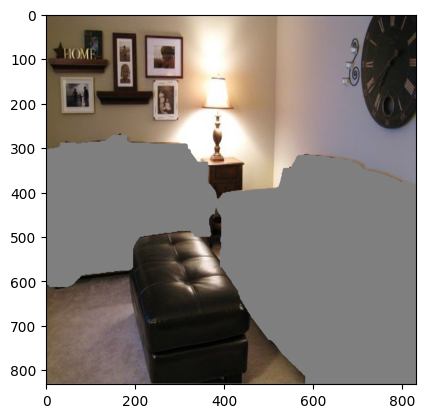

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

arr = masked_image.cpu().numpy()
arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = "dynavision.safetensors"
clip_skip = -2

checkpoint_loader = CheckpointLoaderSimple()
model, clip_model, vae = checkpoint_loader.load_checkpoint(
    ckpt_name=checkpoint_path
)

In [ ]:
clip_model

In [ ]:
clip_layer = CLIPSetLastLayer()
text_encoder = CLIPTextEncode()

clip, = clip_layer.set_last_layer(
    clip_model,
    stop_at_clip_layer=clip_skip
)
clip

In [ ]:
positive_cond = text_encoder.encode(
    text=prompt,
    clip=clip
)[0]

negative_cond = text_encoder.encode(
    text=negative_prompt,
    clip=clip
)[0]

positive_cond, negative_cond

([[tensor([[[-3.6753, -2.1969,  4.1147,  ...,  0.0690,  0.4754, -0.2256],
            [-0.3104,  0.7467,  0.6022,  ...,  0.9568,  0.6341,  0.4178],
            [ 1.0281, -0.5404,  0.3393,  ...,  0.6339,  0.1420,  0.6554],
            ...,
            [ 1.9925, -0.2806, -1.5043,  ..., -0.0793,  1.1525,  1.0289],
            [ 1.9901, -0.2823, -1.5051,  ..., -0.1323,  1.0218,  1.0910],
            [ 1.9956, -0.2387, -1.4729,  ..., -0.0958,  1.1128,  1.1048]]]),
   {'pooled_output': tensor([[-0.1102,  0.7341,  0.8910,  ..., -0.3899, -1.3152, -0.2642]])}]],
 [[tensor([[[-3.6753, -2.1969,  4.1147,  ...,  0.0690,  0.4754, -0.2256],
            [ 0.4818,  0.2372,  0.1025,  ...,  0.0808,  0.2006,  0.0907],
            [-0.2934, -0.7364,  1.9350,  ...,  0.0957,  1.4638,  0.3339],
            ...,
            [-0.3084,  0.5823, -0.3434,  ..., -0.0167,  0.7372,  0.7711],
            [-0.3045,  0.5919, -0.3474,  ..., -0.0646,  0.6185,  0.8078],
            [-0.2788,  0.5752, -0.3787,  ..., -0.0143

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# Encode image to latent space
vae_encode = VAEEncode()
masked_latent = vae_encode.encode(masked_image)[0]
masked_latent.shape

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
# Set up differential diffusion
diff_diff = DifferentialDiffusion()
model = diff_diff.apply(model)[0]
model

In [ ]:
# Apply perturbed attention guidance
pag_scale = 3
pag = PerturbedAttentionGuidance()
model = pag.patch(model, scale=pag_scale)[0]
model

In [ ]:
sys.path.append("/content/drive/MyDrive/MuralinkWorkflows/Checkpoints/")

In [ ]:
sys.path.append("/content/drive/MyDrive/MuralinkWorkflows/Checkpoints/inpaint")

In [ ]:
brushnet_path = "/content/drive/MyDrive/MuralinkWorkflows/Checkpoints/inpaint/random_mask_brushnet_ckpt_sdxl_v0.safetensors"

brushnet_loader = BrushNetLoader()

brushnet_model = brushnet_loader.brushnet_loading(
            brushnet=brushnet_path,
            dtype="float16"
        )

AttributeError: 'BrushNetLoader' object has no attribute 'inpaint_files'

In [ ]:
brushnet = BrushNet()
output = brushnet.model_update(
    model=model,
    vae=vae,
    image=masked_image,
    mask=mask,
    brushnet=brushnet_model,
    positive=positive_cond,
    negative=negative_cond,
    scale=brushnet_scale,
    start_at=start_step,
    end_at=end_step
)[0]

AttributeError: 'BrushNetLoader' object has no attribute 'inpaint_files'

In [ ]:
if num_samples > 1:
    repeat = RepeatLatentBatch()
    output = repeat.repeat(output, num_samples)[0]

# Sample with updated parameters
sampler = KSampler()
samples = sampler.sample(
    model=model,
    seed=seed,
    steps=num_inference_steps,
    cfg=guidance_scale,
    sampler_name=sampler,
    scheduler=scheduler,
    denoise=1,
    positive=positive_cond,
    negative=negative_cond,
    latent_image=output
)[0]

# Decode all samples
decoder = VAEDecode()
images = decoder.decode(samples)[0]

# Convert to PIL images
pil_images = []
for img in images:
    img_np = (img.cpu().numpy() * 255).astype(np.uint8)
    pil_images.append(Image.fromarray(img_np))

make_image_grid(pil_images, rows = 1, cols = len(pil_images))

TypeError: '>' not supported between instances of 'tuple' and 'int'

In [ ]:
# prompt: load and resize image and save

import cv2
from PIL import Image

def resize_and_save_image(image_path, output_path, target_size=(512, 512)):
    try:
        img = Image.open(image_path)
        img = img.resize(target_size)
        img.save(output_path)
        print(f"Image resized and saved to {output_path}")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
resize_and_save_image("/content/drive/MyDrive/muralink_trials/living_room.jpg", "resized_image.jpg")